In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from neuralhedge.nn import datahedger, functional, mlp
from neuralhedge.dynamic import stochastic
from neuralhedge._utils.plotting import plot_pnl, plot_history

from importlib import reload
reload(datahedger)

torch.manual_seed(1)

<module 'neuralhedge.nn.datahedger' from '/Users/hous/Documents/GitHub/NeuralHedge/neuralhedge/nn/datahedger.py'>

### Black Scholes Model

In [2]:
n_paths = 5000
step_size = 1/365
maturity = 30/365
n_steps = ceil(maturity / step_size)
initial_price = 1.

blackscholes = stochastic.BlackScholes()
prices = blackscholes.stimulate(n_paths, n_steps, step_size, initial_price)
payoff = functional.european_payoff(prices[:,-1,0], call=True, strike=1.)

time_to_maturity = torch.linspace(maturity, 0, n_steps+ 1)
time_to_maturity = torch.tile(time_to_maturity, [n_paths,1])[...,None]

information = torch.cat([
    torch.log(prices),
    time_to_maturity
    ], axis = -1)

n_asset = prices.shape[-1]
data_set = [prices, information, payoff]

### Data Hedger

/opt/homebrew/Caskroom/miniforge/base/envs/NeuralHedge/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Loss=0.023319195955991745: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


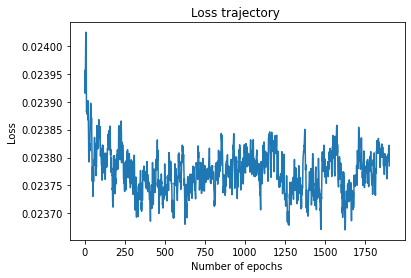

In [3]:
dataset_market = datahedger.MarketDataset(data_set)
model = mlp.NeuralNet(n_output = n_asset)
hedger = datahedger.Hedger(model) 
history = hedger.fit(dataset_market, EPOCHS=100)    
plot_history(history)

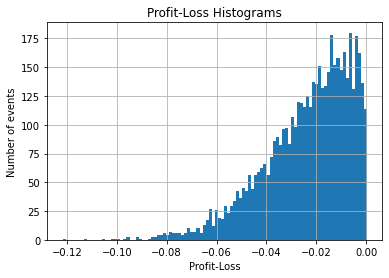

Price:  0.023761064


In [4]:
pnl = hedger.compute_pnl(data_set).detach().numpy()
plot_pnl(pnl)
print('Price: ', hedger.pricer().detach().numpy())

### Deep Hedger

Loss=0.016227543354034424: 100%|██████████| 200/200 [00:35<00:00,  5.60it/s]


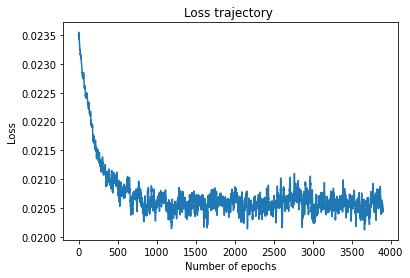

In [8]:
models = [mlp.NeuralNet(n_output = n_asset) for t in range(n_steps)]
hedger = datahedger.DeepHedger(models) 
history = hedger.fit(dataset_market, EPOCHS=200)    
plot_history(history)

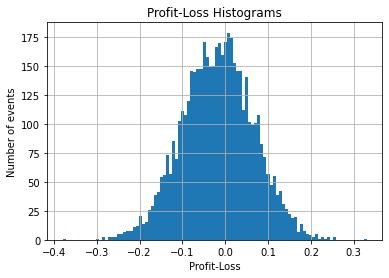

Price:  0.020510137


In [9]:
pnl = hedger.compute_pnl(data_set).detach().numpy()
plot_pnl(pnl)
print('Price: ', hedger.pricer().detach().numpy())

### Heston Model